In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn_pandas import gen_features
from sklearn_pandas import DataFrameMapper
from sklearn.impute import KNNImputer
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score
import lightgbm
from sklearn.preprocessing import minmax_scale

### Попередній аналіз даних

In [2]:
df = pd.read_csv('train.csv', index_col='PassengerId')
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
check_df = df[['Survived']]
check_df.head(3)

,Survived
PassengerId,
1,0
2,1
3,1


In [5]:
for col in df.columns:
    if df[col].nunique() < 11:
        print('{} values: {}'.format(df[col].name, df[col].unique()))
    else:
        print('{} - number of values {}'.format(df[col].name, df[col].nunique()))

Survived values: [0 1]
Pclass values: [3 1 2]
Name - number of values 891
Sex values: ['male' 'female']
Age - number of values 88
SibSp values: [1 0 3 4 2 5 8]
Parch values: [0 1 2 5 3 4 6]
Ticket - number of values 681
Fare - number of values 248
Cabin - number of values 147
Embarked values: ['S' 'C' 'Q' nan]


Видалення змінних, що не можуть бути застосовані в кластеризації

In [6]:
df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
# видалено змінні з великою кількістю унікальних значень, які не характеризують окремі групи (кластери)

### Розвідка даних

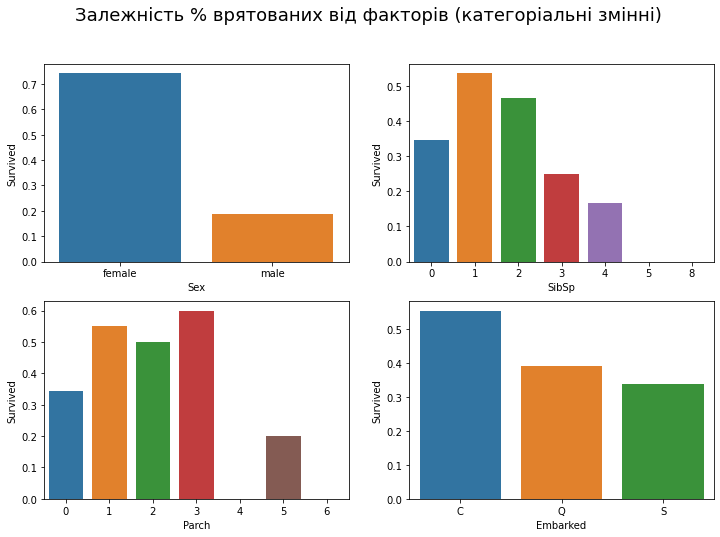

In [7]:
df['count'] = 1
group_by = ['Sex', 'SibSp', 'Parch', 'Embarked']
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for col, ax in zip(group_by, axs.flatten()):
    df_split = df.groupby(col).agg({'count': np.sum, 'Survived': np.sum})
    df_split['Survived'] = df_split['Survived'] / df_split['count']
    df_split['x'] = df_split.index
    sns.barplot(x='x', y='Survived', data=df_split, ax=ax)
    ax.set_xlabel(col)
plt.suptitle('Залежність % врятованих від факторів (категоріальні змінні)', fontsize=18)
plt.show()

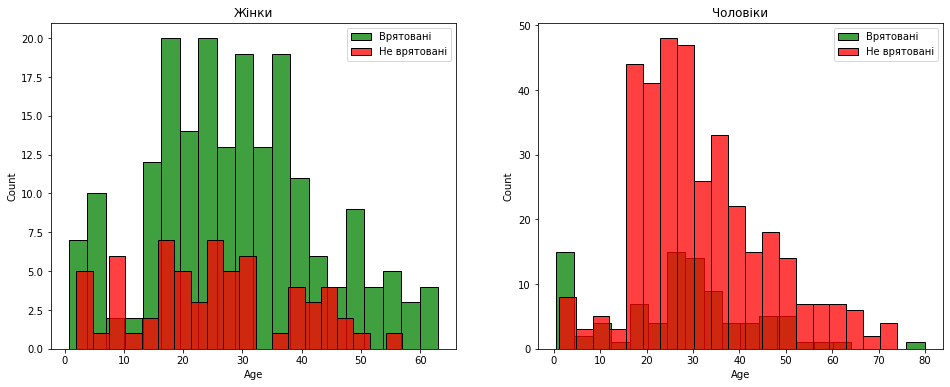

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
women = df.loc[df['Sex']=='female']
men = df.loc[df['Sex']=='male']
sns.histplot(women[women['Survived']==1].Age.dropna(), bins=20, label = 'Врятовані', ax = axes[0], kde = False, color="green")
sns.histplot(women[women['Survived']==0].Age.dropna(), bins=20, label = 'Не врятовані', ax = axes[0], kde = False, color="red")
axes[0].legend()
axes[0].set_title('Жінки')
sns.histplot(men[men['Survived']==1].Age.dropna(), bins=20, label = 'Врятовані', ax = axes[1], kde = False, color="green")
sns.histplot(men[men['Survived']==0].Age.dropna(), bins=20, label = 'Не врятовані', ax = axes[1], kde = False, color="red")
axes[1].legend()
axes[1].set_title('Чоловіки');

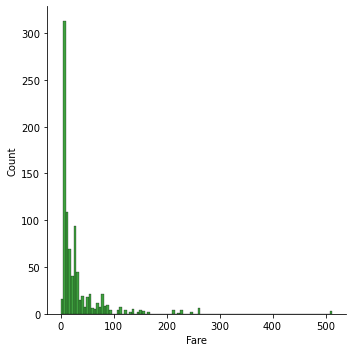

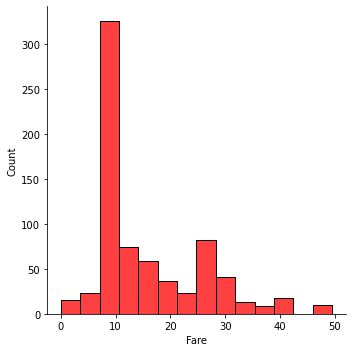

In [9]:
sns.displot(df.Fare, color='green')
sns.displot(df.loc[df.Fare < 50].Fare, color='red')

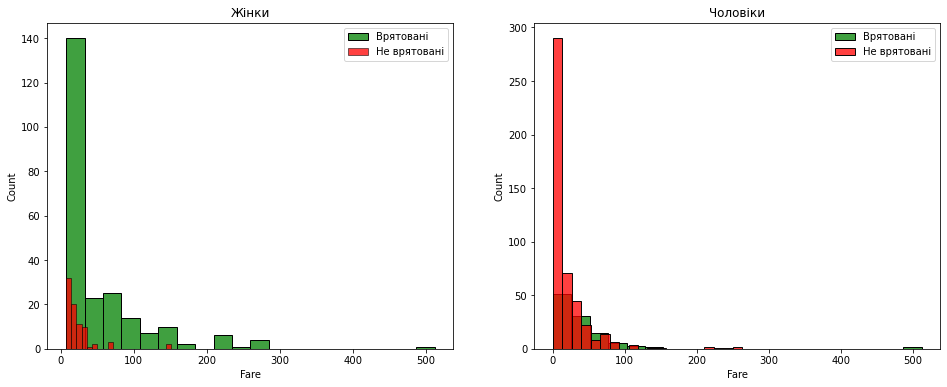

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
women = df.loc[df['Sex']=='female']
men = df.loc[df['Sex']=='male']
sns.histplot(women[women['Survived']==1].Fare.dropna(), bins=20, label = 'Врятовані', ax = axes[0], kde = False, color="green")
sns.histplot(women[women['Survived']==0].Fare.dropna(), bins=20, label = 'Не врятовані', ax = axes[0], kde = False, color="red")
axes[0].legend()
axes[0].set_title('Жінки')
sns.histplot(men[men['Survived']==1].Fare.dropna(), bins=20, label = 'Врятовані', ax = axes[1], kde = False, color="green")
sns.histplot(men[men['Survived']==0].Fare.dropna(), bins=20, label = 'Не врятовані', ax = axes[1], kde = False, color="red")
axes[1].legend()
axes[1].set_title('Чоловіки');

In [11]:
df.drop(columns=['Fare', 'count', 'Survived'], inplace=True)
# видалено змінні, між якими та таргетною змінною нема кореляції та допоміжний стовпчик

In [12]:
# отримана в результаті первинного аналізу таблиця даних, що буде використана для кластеризації
df.head(3)

,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,
1,3,male,22.0,1,0,S
2,1,female,38.0,1,0,C
3,3,female,26.0,0,0,S


In [13]:
categoricals = [item for item in df.columns if item != 'Age']
numericals = ['Age']
for item in categoricals:
    df[item] = df[item].astype('category')

In [14]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    891 non-null    category
 1   Sex       891 non-null    category
 2   Age       714 non-null    float64 
 3   SibSp     891 non-null    category
 4   Parch     891 non-null    category
 5   Embarked  889 non-null    category
dtypes: category(5), float64(1)
memory usage: 19.3 KB


### Категорийні NaNs

In [15]:
# кількість NaN по кожному признаку
df.isna().sum().loc[df.isna().sum() > 0].sort_values(ascending=True)

Embarked      2
Age         177
dtype: int64

In [16]:
feature_def = gen_features(
              columns=[['Embarked']],
              classes=[{'class': SimpleImputer, 'strategy':'most_frequent'}])
mapper = DataFrameMapper(feature_def)
df['Embarked'] = mapper.fit_transform(df).ravel()

### Кодування категорийних змінних

In [17]:
oe_data = OrdinalEncoder().fit_transform(df[['Sex', 'Embarked']])
df['Sex'] = pd.Series(oe_data[:, 0]).astype('category')
df['Embarked'] = pd.Series(oe_data[:, 1]).astype('category')

### Нумеричні NaN (вік)

In [18]:
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(np.array(df)), index=df.index, columns=df.columns)
df_imputed.head(5)

,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,
1,3.0,0.0,22.0,1.0,0.0,0.0
2,1.0,0.0,38.0,1.0,0.0,2.0
3,3.0,0.0,26.0,0.0,0.0,2.0
4,1.0,1.0,35.0,1.0,0.0,2.0
5,3.0,1.0,35.0,0.0,0.0,1.0


In [19]:
df = df_imputed.copy()
df.isna().sum().loc[df.isna().sum() > 0].sort_values(ascending=True)

Series([], dtype: int64)

In [20]:
df = df.astype('int64')

### Кластеризація

In [21]:
df['Age'] = minmax_scale(np.array(df['Age']), feature_range=(0, 1))

In [22]:
def kproto_scorring(data, met_col, cat_col, n):
    c_col = [item[0] for item in enumerate(cat_col) if item[1] in cat_col]
    clf_kp = lightgbm.LGBMClassifier(colsample_bytree=0.8)
    kproto = KPrototypes(n_clusters= n, init='Cao', n_jobs = 6)
    clusters = kproto.fit_predict(data, categorical=c_col)
    cv_scores_kp = cross_val_score(clf_kp, data, clusters, scoring='f1_weighted')
    sl_coef = silhouette_score(data[met_col], kproto.labels_)
    ct_coef = kproto.cost_
    return cv_scores_kp, sl_coef, ct_coef

In [23]:
f1_scores, sl_scores, ct_scores = {}, {}, {}
for n in range(2, 9):
    f1, sl, ct = kproto_scorring(df, numericals, categoricals, n)
    f1_scores.update({n: f1})
    sl_scores.update({n: sl})
    ct_scores.update({n: ct})

In [24]:
sl_values = minmax_scale(np.array(list(sl_scores.values())), feature_range=(0, 1))
ct_values = minmax_scale(np.array(list(ct_scores.values())), feature_range=(0, 1))

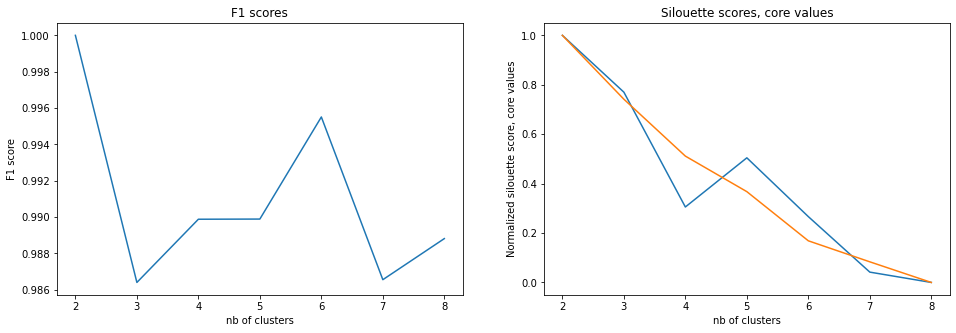

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
scores_to_plot = [np.mean(f1_scores[item]) for item in f1_scores.keys()]
ax[0].plot(list(f1_scores.keys()), scores_to_plot)
ax[0].set_xlabel('nb of clusters')
ax[0].set_ylabel('F1 score')
ax[0].set_title('F1 scores')

ax[1].plot(list(f1_scores.keys()), sl_values)
ax[1].plot(list(f1_scores.keys()), ct_values)
ax[1].set_xlabel('nb of clusters')
ax[1].set_ylabel('Normalized silouette score, core values')
ax[1].set_title('Silouette scores, core values')

plt.show()

In [26]:
kproto = KPrototypes(n_clusters=3, init='Cao', n_jobs = 6)
df['kproto_labels'] =  kproto.fit_predict(df, categorical=[item[0] for item in enumerate(categoricals) if item[1] in categoricals])

In [27]:
df.head(5)

,Pclass,Sex,Age,SibSp,Parch,Embarked,kproto_labels
PassengerId,,,,,,,
1,3,0,0.2750,1,0,0,2
2,1,0,0.4750,1,0,2,1
3,3,0,0.3250,0,0,2,1
4,1,1,0.4375,1,0,2,0
5,3,1,0.4375,0,0,1,0


In [28]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Отображение parallel plot для средних значений переменных в каждом кластере
    Гистограмма количества элементов полученных кластеров
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Фильтрация df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Определение центроид и количества элементов в кластере
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Построение графиков
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        # Настройка отображения графиков
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Номер кластера - {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # подстройка под количество кластеров
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Средние кластеров - {} кластера (-ов)".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Абсолютная частота")
        ax[1].set_title("Размер кластеров - {} кластера (-ов)".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Профайл кластеров", fontsize=23)
    plt.show()

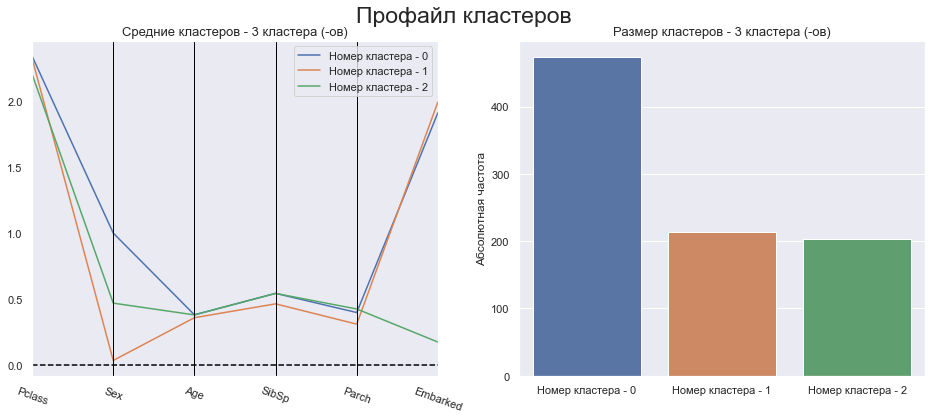

In [29]:
cluster_profiles(df, ['kproto_labels'], (16, 6))